In [9]:
import pandas as pd
import numpy as np
import gensim
from konlpy.tag import Okt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
import re
import ast
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm import tqdm
import time

In [10]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\cg063\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [11]:
train = pd.read_json('./origin_data_modify/train_mod5.json', typ='frame')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80953 entries, 0 to 80952
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          80953 non-null  object
 1   id            80953 non-null  int64 
 2   plylst_title  80953 non-null  object
 3   songs         80953 non-null  object
 4   like_cnt      80953 non-null  int64 
 5   updt_date     80953 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.3+ MB


In [12]:
train['tags'][11219] # 11215 11219

['휴식', '밤', '잔잔한', '어두운', '새벽', '힐링', '조용한']

In [13]:
words = train['tags'][11219]

stemmer = PorterStemmer()
okt = Okt()

for word in words:
	print(okt.nouns(word))

['휴식']
['밤']
[]
['어', '두운']
['새벽']
['힐링']
[]


In [14]:
# train['tags'] unset 진행
tags_list = train.explode('tags')['tags'].values.tolist()
len(tags_list)

350289

In [15]:
# 유니크 태그만 남기기
unique_tag = list(set(tags_list))
len(unique_tag) # 24448

24448

In [16]:
unique_tag

['',
 '나오는곡마다대박',
 '동생',
 '벚꽃낭만',
 '개발자',
 '한국음악',
 '훈내',
 '더겟다운',
 '초겨울',
 'HuskerDu',
 '핫랩퍼',
 '추적추적',
 '초반',
 '자메이카',
 '봄바람',
 '감성pop',
 '노을보며',
 '화보모델',
 '비교',
 '말복',
 '평온',
 '세트리스트',
 '박웅',
 '워터파크',
 '알앤비발라드',
 'postbritpop',
 '칩멍크소울',
 '봄맞이플레이리스트',
 '블링크182',
 '중독',
 '딩고프리스타일',
 '200215',
 '대장님',
 '결혼장려',
 'britpop',
 'DVBBS',
 '잠잘때듣는음악',
 '독립영화OST',
 '알앤비보컬',
 '혼자사랑',
 '크리스토퍼내한',
 '합체하면천상의소리',
 '볾',
 '요가는귀로하자',
 '스피닝댄스',
 '두근',
 '봄소풍',
 'Galaxy',
 '박성연',
 '앳모스피어',
 '밝은노래',
 '시대극드라마',
 '취항저격',
 '아드리아나깔까뇨뚜',
 'Prokofiev',
 '소근소근',
 '브리튼치즈',
 '오타쿠',
 '외로울때듣기좋은노래',
 '예쁜걸',
 '00년생',
 '비장함',
 '끈적한',
 '스트레스타파',
 '문별',
 '유익종',
 '기말고사',
 '스타테너',
 '청소할때',
 '베이퍼웨이브',
 '노래듣기',
 '자',
 '3월2주차',
 '아이즈전곡듣기',
 '여휴',
 'k인디',
 '불쾌지수',
 '타이틀감수록곡',
 '술한잔',
 '빌보드순위',
 '쉬자',
 '13명의',
 'Bazzi',
 '강아지가좋아하는',
 'tobu',
 '소름끼치는노래',
 '방탄소년단명곡',
 '지은지',
 '데프콘',
 '김명식',
 '폼나는노래',
 '캐롤모음',
 'AlessiaCara',
 '빌위더스',
 '임태수',
 '펄잼',
 'Sade',
 '요즘것들',
 '역동적인',
 'Hymnal',
 '엘라피츠제랄드',
 '숨어서듣는명곡',
 'EDMPOP',
 '흥재즈',
 

- 유사한 단어들끼리 군집화 후 군집 별 lable 달아주기

In [17]:
okt = Okt()

tagged_data = [] # 89개의 TaggedDocument
for i in range(len(unique_tag)) :
  tagged_document = TaggedDocument(words=unique_tag[i], tags=[str(unique_tag[i])])
  tagged_data.append(tagged_document)

len(tagged_data)

24448

In [18]:
sorted_word_list = sorted(unique_tag, key=len, reverse=True)
sorted_word_list

['외모와연주실력모두갖춘클래식아티스트',
 'BillboardDecember',
 'TheSoundofCHANEL',
 'SebastienTellier',
 '5secondsofsummer',
 'FuturisticSwaver',
 '피아노바이올린협주곡관현악클래식',
 '커피숍매장라운지자장가추천클래식',
 '매장커피숍호텔로비추천인기클래식',
 '카페커피숖호텔라운지에서듣는재즈',
 'BlueBottleCoffee',
 '프로듀스101시즌2포지션평가곡',
 'Justinhartinger',
 '매장커피숖호텔라운지추천클래식',
 '투모로우바이투게더플레이리스트',
 '피아노탱고왈츠오보에플룻클래식',
 'StrangerThings3',
 '멜론디제이니가뭔데삭제못하게해',
 '코로나는코리아를이길수없습니다',
 'GirlsGeneration',
 '프로듀스101시즌2컨셉평가곡',
 'DharmaWorldwide',
 'alternativerock',
 '스트레스해소인기추천힐링클래식',
 '내가듣고싶어서만든플레이리스트',
 '망할게뻔한모험을부추기는노래들',
 '5Secondofsummer',
 'LiveNationKorea',
 'HotelCalifornia',
 '우리아이를위한태교자장가클래식',
 'holidayland2019',
 '누군가생각나는것만같은갬성힙합',
 'KathleenFerrier',
 'BlackMusicChild',
 '스트레스해소힐링인기첼로클래식',
 'BJtheChicagoKid',
 '휴식시간휴가에들으면좋은클래식',
 'WELOVEVOCAELEDM',
 'LuvJonesRecords',
 'AnthonyHamilton',
 'TheRhapsodyTour',
 'ViennaBoysChoir',
 '책읽을때적당히틀어놓기좋은음악',
 'ChildishGambino',
 'URBANPLAYGROUND',
 '힘든데기댈사람이없을때듣는노래',
 'CigarettesAfter',
 '스트레스해소힐링추천인기클래식',
 'britishinvasion',
 'Jea

In [19]:
len(sorted_word_list[0])

18

In [20]:
# Doc2Vec 적용(문서 -> 숫자)
# dm=0 => DBOW 알고리즘 사용(단어 순서 고려 X)
# epochs => 같은 데이터에 대해 3번 학습을 반복

model = Doc2Vec(vector_size=20, dm=0, epochs=40)
model.build_vocab(tagged_data)

In [21]:
model.corpus_count

24448

In [22]:
# train 사용
model.train(corpus_iterable=tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

- Doc2Vec의 결과 확인

In [23]:
model.dv.most_similar('kpop')

[('ukpop', 0.9885932803153992),
 ('kingofpop', 0.9846909642219543),
 ('kpip', 0.9840630888938904),
 ('postpunk', 0.9808107614517212),
 ('punk', 0.9789848923683167),
 ('uptownfunk', 0.9787024855613708),
 ('punkrock', 0.9761987924575806),
 ('price', 0.9740433692932129),
 ('pitchperfect', 0.9724410772323608),
 ('kokobop', 0.9694169163703918)]

In [24]:
model.dv.most_similar('크리스마스')

[('크리스마스테마', 0.967354953289032),
 ('메리크리스마스', 0.965526819229126),
 ('크리스마스파티', 0.9600307941436768),
 ('마스크', 0.9597345590591431),
 ('마리스얀손스', 0.944582462310791),
 ('케이크', 0.944179356098175),
 ('스마트폰', 0.9424847364425659),
 ('마이크', 0.9379069209098816),
 ('크리스마스찬양', 0.9353336095809937),
 ('크리스마스니까', 0.9347432851791382)]

In [25]:
model.dv.most_similar('캐롤')

[('캐롤킹', 0.9754298329353333),
 ('롤', 0.9571995139122009),
 ('캐럿', 0.95184326171875),
 ('캐논', 0.9405519366264343),
 ('캐럴', 0.9326024055480957),
 ('샤캐', 0.9155259728431702),
 ('롹앤롤', 0.9106718301773071),
 ('비캐롤', 0.8791071772575378),
 ('잠캐롤', 0.8733752369880676),
 ('락큰롤', 0.8729236125946045)]

In [26]:
model.dv.most_similar('여행')

[('배낭여행', 0.9693571329116821),
 ('여름여행', 0.9598297476768494),
 ('여행길', 0.958213746547699),
 ('여행곡', 0.9570103287696838),
 ('혼여행', 0.9546204209327698),
 ('잉여', 0.943061113357544),
 ('여친', 0.940399169921875),
 ('여행길과', 0.9372789859771729),
 ('여행설렘', 0.9366908669471741),
 ('여행자', 0.9364089965820312)]

In [27]:
model.dv.most_similar('Pop')

[('PopRap', 0.975800633430481),
 ('PopRock', 0.9592505693435669),
 ('Pokemon', 0.9586785435676575),
 ('LovePoem', 0.953403651714325),
 ('LilPump', 0.9498651027679443),
 ('Poplatino', 0.9498505592346191),
 ('ElectricPop', 0.9456261396408081),
 ('PostBop', 0.9454249143600464),
 ('Prod', 0.9450281262397766),
 ('IndiePop', 0.9446038603782654)]

In [28]:
model.dv.most_similar('발라드')

[('갓발라드', 0.9869605302810669),
 ('발라드및', 0.9832789897918701),
 ('롹발라드', 0.9812321662902832),
 ('발라드랩', 0.9761165976524353),
 ('랩발라드', 0.9719709753990173),
 ('발라더', 0.965907633304596),
 ('라붐', 0.9598185420036316),
 ('룰라', 0.9597398638725281),
 ('온리발라드', 0.9553856253623962),
 ('라벨', 0.9512471556663513)]

In [29]:
model.dv.vectors.shape

(24448, 20)

In [30]:
model.dv.vectors

array([[-0.02615408, -0.02989563, -0.04940377, ...,  0.04612811,
        -0.04750933, -0.01729043],
       [-0.05567313,  0.25157076,  0.3067478 , ..., -0.29343748,
         0.16418152,  0.23790498],
       [-0.16786131,  0.07153168,  0.15770924, ..., -0.02957605,
         0.27079174,  0.33710787],
       ...,
       [ 0.01147674, -0.31346494,  0.6767343 , ..., -0.08442666,
         0.5696412 , -0.23001534],
       [-0.21734336,  0.16176687,  0.32082534, ...,  0.19875315,
        -0.0698471 ,  0.07223738],
       [-0.41068563,  0.10423384,  0.58497626, ..., -0.08249331,
         0.4081589 ,  0.28968015]], dtype=float32)

In [31]:
doc_representations = model.dv.vectors
doc_representations.shape

(24448, 20)

In [32]:
df_new = pd.DataFrame()
df_new['tag_name'] = model.dv.index_to_key # 영화마다 군집화하게되면 군집별로 번호가 붙인다
df_new.head()

,tag_name
0,
1,나오는곡마다대박
2,동생
3,벚꽃낭만
4,개발자


- 군집화

In [33]:
# k-means 군집화 알고리즘을 사용해 클러스터 개수를 조절하면서 왜곡을 계산

distortions = [] # 왜곡값을 저장할 빈 리스트 생성

for k in tqdm(range(1, 100), desc="K-Means Clustering Progress"):  # range 범위 내의 k에 대해 반복
    kmeans = KMeans(n_clusters=k, n_init=10)  # n_init 초기화 횟수
    kmeans.fit(doc_representations)  # 비지도 학습 수행
    distortions.append(kmeans.inertia_)

K-Means Clustering Progress: 100%|██████████| 99/99 [09:26<00:00,  5.72s/it]


In [34]:
distortions

[17181.041015625,
 14407.8701171875,
 13504.400390625,
 12891.841796875,
 12379.8330078125,
 11981.689453125,
 11677.421875,
 11407.552734375,
 11192.3544921875,
 10988.953125,
 10811.25390625,
 10664.2138671875,
 10517.9765625,
 10392.994140625,
 10293.6826171875,
 10189.3017578125,
 10099.283203125,
 10003.3046875,
 9922.3935546875,
 9844.78515625,
 9744.1640625,
 9672.7958984375,
 9608.2236328125,
 9544.66015625,
 9487.619140625,
 9420.3095703125,
 9378.0400390625,
 9295.494140625,
 9250.7294921875,
 9210.703125,
 9136.98046875,
 9100.525390625,
 9044.041015625,
 9006.888671875,
 8962.1884765625,
 8914.345703125,
 8888.6005859375,
 8843.583984375,
 8788.6708984375,
 8757.8896484375,
 8710.927734375,
 8688.39453125,
 8658.8994140625,
 8615.12109375,
 8590.6630859375,
 8557.5400390625,
 8513.7490234375,
 8476.2109375,
 8449.3994140625,
 8424.8798828125,
 8380.501953125,
 8357.34765625,
 8331.0927734375,
 8304.6279296875,
 8272.3056640625,
 8247.88671875,
 8217.619140625,
 8189.1210937

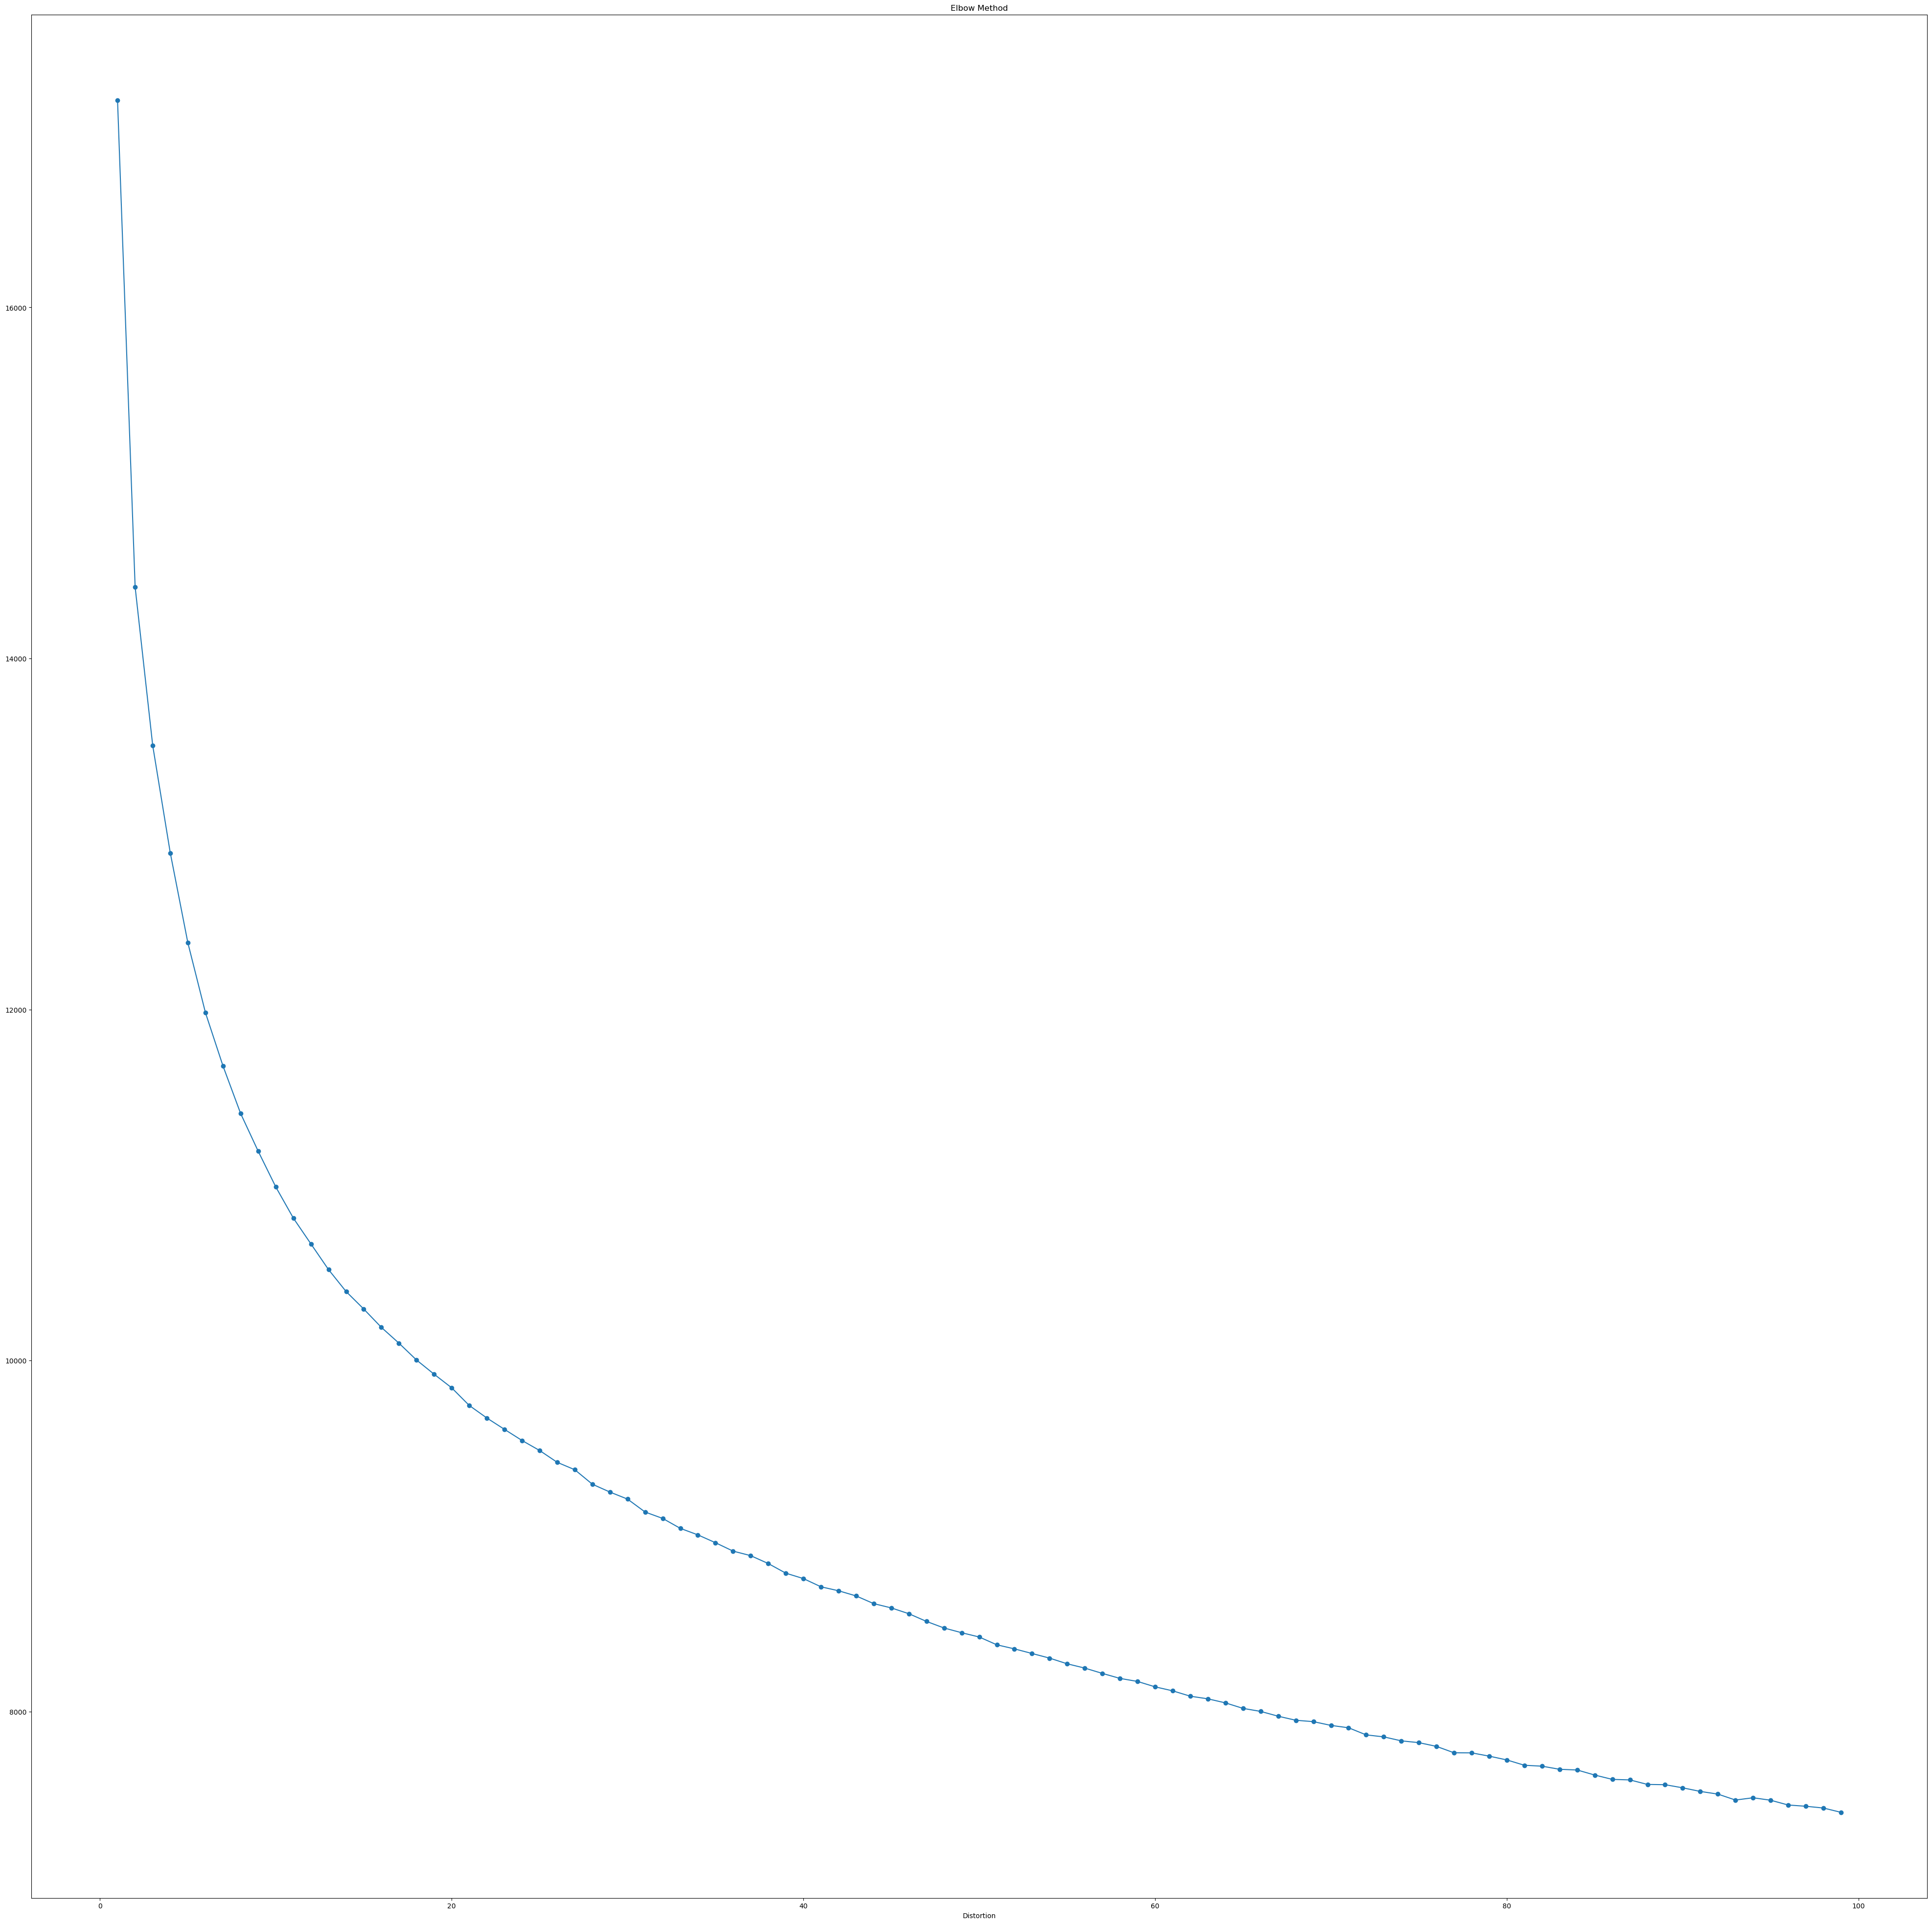

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))
plt.plot(range(1, 100), distortions, 'o-')
plt.xlabel('k')
plt.xlabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [36]:
selected_k=100
kmeans = KMeans(n_clusters=selected_k, n_init=10)
kmeans.fit(doc_representations)
kmeans.labels_

array([96, 33, 72, ..., 66, 41, 77])

In [37]:
df_new['그룹'] = kmeans.labels_
df_new['그룹'].value_counts()

4     1257
14     558
3      511
44     435
82     395
      ... 
78      96
27      91
0       91
42      70
96      50
Name: 그룹, Length: 100, dtype: int64

In [38]:
df_new.loc[df_new['그룹'] == 0, :]

,tag_name,그룹
78,술한잔,0
1393,잔잔한사랑팝,0
1778,한잔해,0
1934,잔잔한멜로디,0
2042,새벽감성잔잔한,0
...,...,...
23581,애잔한,0
23835,잔잔한노래는잠시휴업,0
23856,노래는신몽잔발,0
23917,한잔에,0


In [39]:
df_new.loc[df_new['그룹'] == 15, :]

,tag_name,그룹
99,Hymnal,15
163,Justinhartinger,15
189,wooney,15
314,radioheadlive,15
328,standbyyourmen,15
...,...,...
24298,Whiteday,15
24326,georgemartin,15
24327,avantgarde,15
24352,gryffin,15


In [40]:
df_new.loc[df_new['그룹'] == 50, :]

,tag_name,그룹
16,노을보며,50
112,설렘노래,50
119,후렴에서터지는노래,50
291,빡신노래들,50
511,드라이한노래,50
...,...,...
24056,달달한노래,50
24068,지미노래,50
24127,위로되는노래를,50
24211,첫눈노래,50


In [41]:
df_new.loc[df_new['그룹'] == 75, :]

,tag_name,그룹
106,시애틀,75
128,중학교시절,75
313,슈가맨시즌2,75
492,케이시,75
496,전시관,75
...,...,...
23973,시원한태양,75
24312,퇴근시간,75
24315,속시원,75
24341,역시,75


In [42]:
df_new.loc[df_new['그룹'] == 99, :]

,tag_name,그룹
68,청소할때,99
156,멍때리고,99
224,감성이필요할때,99
393,더울때,99
666,조깅할때,99
...,...,...
23914,집중이필요할때,99
24045,힘이들때,99
24295,지쳤을때,99
24318,마할리아,99
